# <span style='color:blue'> Final Project: </span>
# <span style='color:blue'> Meteostat </span>

In [191]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler
from meteostat import Point, Daily, Hourly, Stations
import torch
import torch.utils.data as data_utils


## Prepare Data

In [192]:
# Want to remove NaN entries and build a temperature model from sufficient data

lat = 47.6
lon = -122.3
start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2000, 1, 1)
data=Daily(Point(lat,lon), start=start, end=end).fetch()
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1970-01-01,NaN,1.7,5.6,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1970-01-02,NaN,1.1,6.7,0.0,0.0,NaN,NaN,NaN,NaN,438.0
1970-01-03,NaN,0.6,5.0,0.0,0.0,NaN,NaN,NaN,NaN,102.0
1970-01-04,NaN,-1.7,4.4,0.0,0.0,NaN,NaN,NaN,NaN,444.0
1970-01-05,NaN,-1.1,5.0,0.0,0.0,NaN,NaN,NaN,NaN,354.0


In [193]:
data.shape

(10958, 10)

<AxesSubplot:xlabel='time'>

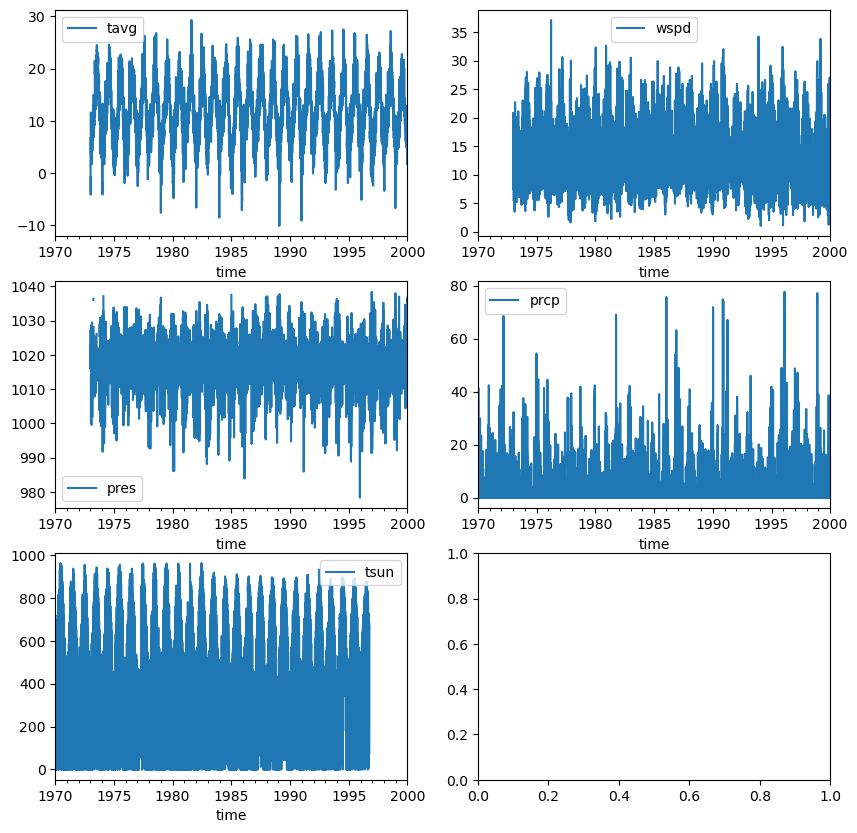

In [194]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

data['tavg'].plot(ax=ax[0][0], legend=True)
data['wspd'].plot(ax=ax[0][1], legend=True)
data['pres'].plot(ax=ax[1][0], legend=True)
data['prcp'].plot(ax=ax[1][1], legend=True)
data['tsun'].plot(ax=ax[2][0], legend=True)

# As you can see, there is a gap in the data ~ 1970. However, we can get sufficient data by stating ~ 1975

In [195]:
data['tsun'].plot(ax=ax[2][0], legend=True)

<AxesSubplot:xlabel='time'>

In [196]:
# Define start and end times
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2023, 1, 1)

data = Hourly(Point(lat,lon), start=start, end=end).fetch()

# Find how much data we have
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87649 entries, 2013-01-01 00:00:00 to 2023-01-01 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    87649 non-null  float64
 1   dwpt    87649 non-null  float64
 2   rhum    87649 non-null  float64
 3   prcp    87138 non-null  float64
 4   snow    0 non-null      float64
 5   wdir    86667 non-null  float64
 6   wspd    87649 non-null  float64
 7   wpgt    0 non-null      float64
 8   pres    87648 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    42953 non-null  float64
dtypes: float64(11)
memory usage: 8.0 MB


In [197]:
# Extract all relevant channels and impute and missing values
data_cleaned = data[['temp', 'dwpt', 'prcp', 'wspd', 'wdir','pres']]
print(data_cleaned.isna().any())

# Use linear interpolation to fill in NA values
data_cleaned['temp'].interpolate(method='linear', inplace=True)
data_cleaned['dwpt'].interpolate(method='linear', inplace=True)
data_cleaned['prcp'].interpolate(method='linear', inplace=True)
data_cleaned['wspd'].interpolate(method='linear', inplace=True)
data_cleaned['wdir'].interpolate(method='linear', inplace=True)
data_cleaned['pres'].interpolate(method='linear', inplace=True)
print(data_cleaned.isna().any())

temp    False
dwpt    False
prcp     True
wspd    False
wdir     True
pres     True
dtype: bool
temp    False
dwpt    False
prcp     True
wspd    False
wdir    False
pres    False
dtype: bool


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [198]:
data_cleaned.columns

Index(['temp', 'dwpt', 'prcp', 'wspd', 'wdir', 'pres'], dtype='object')

In [199]:
# Model takes 1 days and then predicts next day

testing_sequence_len =  48

# Convert to numpy array 
y = data_cleaned[['temp']].values

scaler = StandardScaler()

scaler.fit(y)

y_scaled = scaler.transform(y)

y_train = y_scaled[:-testing_sequence_len]


In [200]:
# Define encoder/decoder sequence lengths and testing sequencce length
encoder_inputseq_len =  24
decoder_outputseq_len = 24
num_features = y_train.shape[1]
num_features

1

In [201]:
def generate_input_output_seqs(y, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = num_features):
  
    L = y.shape[0] # Length of y
    
    # Calculate how many input/target sequences there will be based on the parameters and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # Numpy zeros arrray to contain the input/target sequences
    # Note that they should be in (num_samples, seq_len, num_features/time step) format
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # Iteratively fill in train_input_seqs and train_output_seqs
    # See slide 17 of lab 7 to get an idea of how input_seqs and output_seqs look like
    for ff in np.arange(num_features):
        
        for ii in np.arange(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii, :, ff] = y[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs

In [202]:
# Generate encoder input seqs and decoder output seqs
train_input_seqs, train_output_seqs = generate_input_output_seqs(
    y=y_train,
    encoder_inputseq_len=encoder_inputseq_len,
    decoder_outputseq_len=decoder_outputseq_len,
    stride=1,
    num_features=num_features
)
train_input_seqs.shape

(87554, 24, 1)

In [203]:
# Check the dimensions of encoder input seqs and decoder output seqs
print("Encoder Training Inputs Shape: ", train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", train_output_seqs.shape)

Encoder Training Inputs Shape:  (87554, 24, 1)
Decoder Training Outputs Shape:  (87554, 24, 1)


In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Define Model

In [205]:

class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()

        # Using LSTM for Encoder with batch_first = True
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.fcl1 = torch.nn.Linear(hidden_size, fcl_size)
        # self.fcl2 =torch.nn.Linear(fcl_size, hidden_size)

    def forward(self, input_seq, hidden_state):
        # Move input to GPU if available
        input_seq = input_seq.to(device)
        hidden_state = hidden_state

        lstm_out, hidden = self.lstm(input_seq, hidden_state)
        # hidden = torch.nn.functional.relu(self.fcl1(h1))
        # hidden = self.fcl2(hidden)
        return lstm_out, hidden

class Decoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()

        # Using LSTM for Decoder with batch_first = True
        # fc_decoder for converting hidden states -> single number
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, encoder_hidden_states):
        # Move input to GPU if available
        input_seq = input_seq.to(device)
        encoder_hidden_states = tuple(h.to(device) for h in encoder_hidden_states)

        lstm_out, hidden = self.lstm(input_seq, encoder_hidden_states)
        output = self.fc_decoder(lstm_out)
        return output, hidden

class NN(torch.nn.Module):
    def __init__(self, input_size, fcl_size):
        super(NN, self).__init__()

        self.fcl1 = torch.nn.Linear(input_size, fcl_size)
        self.fcl2 = torch.nn.Linear(fcl_size, input_size)
        self.dropout = torch.nn.Dropout(p=0.25)
    
    def forward(self, input):
        out = torch.nn.functional.tanh(self.fcl1(input))
        out = self.dropout(out)
        out = self.fcl2(out)
        return out

class Encoder_Decoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers, fcl_size):
        # Combine Encoder and Decoder classes into one
        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.Decoder = Decoder(input_size=input_size, hidden_size=hidden_size, output_size=decoder_output_size, num_layers=num_layers)
        self.FCL = NN(input_size=hidden_size, fcl_size=fcl_size)

        # Move model to GPU if available
        self.to(device)


## Define Hyperparameters

In [206]:
# Fix random seed
torch.manual_seed(55)

# Define learning rate + epochs
epochs = 100
learning_rate = 0.001  # Updated learning rate
lr_step_size = 10  # Updated lr_step_size
lr_gamma = 0.1  # Updated lr_gamma
hidden_size = 2  # Updated hidden_size
num_layers = 1


# Using input_size = 1 (# of features to be fed to RNN per timestep)
# Using decoder_output_size = 1 (# of features to be output by Decoder RNN per timestep)
Encoder_Decoder_RNN = Encoder_Decoder(input_size = num_features, hidden_size = hidden_size, decoder_output_size = num_features, num_layers = num_layers, fcl_size=25)
Encoder_Decoder_RNN.to(device)


# Define batch size and num_features/timestep (this is simply the last dimension of train_output_seqs)
batchsize = 512

# Define loss function/optimizer
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Encoder_Decoder_RNN.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)  # Learning rate scheduler

Encoder_Decoder_RNN

Encoder_Decoder(
  (Encoder): Encoder(
    (lstm): LSTM(1, 2, batch_first=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(1, 2, batch_first=True)
    (fc_decoder): Linear(in_features=2, out_features=1, bias=True)
  )
  (FCL): NN(
    (fcl1): Linear(in_features=2, out_features=25, bias=True)
    (fcl2): Linear(in_features=25, out_features=2, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

## Identify Tracked Values

In [207]:
# Empty Python list to keep track of training loss
train_loss_list = []

## Train Model

In [208]:
# Convert training dataset into torch tensors
train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split the training dataset to mini-batches
# Skipping the last mini-batch since its size can be smaller than the set batchsize
train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

# Total number of mini-batches in the training set
batch_split_num = len(train_batches_features)


In [209]:
for epoch in range(epochs): # For each epoch
    
    for k in range(batch_split_num): # For each mini_batch
        
        # initialize hidden states to Encoder
        hidden_state = None
        
        # initialize empty torch tensor array to store decoder output sequence
        decoder_output_seq = torch.zeros(batchsize, decoder_outputseq_len, num_features)
        
        # empty gradient buffer
        optimizer.zero_grad()
        
        # Feed k-th mini-batch for encoder input sequences to encoder with hidden state
        encoder_output, (encoder_hidden, c1) = Encoder_Decoder_RNN.Encoder(train_batches_features[k], hidden_state)

        # Re-define the resulting encoder hidden states as input hidden states to decoder
        encoder_hidden = (Encoder_Decoder_RNN.FCL(encoder_hidden), c1)
        decoder_hidden = encoder_hidden

        
        # Initial input to decoder is last timestep feature from the encoder input sequence
        decoder_input = train_batches_features[k][:, -1, :]
        # The extracted feature is 2D so need to add additional 3rd dimension 
        # to conform to (sample size, seq_len, # of features)
        decoder_input = torch.unsqueeze(decoder_input, 1)
        
        # Populating the decoder output sequence
        for t in range(decoder_outputseq_len): # for each timestep in output sequence
            
            # Feed in the decoder_input and decoder_hidden to Decoder, get new output and hidden states
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            
            # Populate the corresponding timestep in decoder output sequence 
            decoder_output_seq[:, t, :] = torch.squeeze(decoder_output, 2)
            
            # We are using teacher forcing so using the groundtruth training target as the next input        
            decoder_input = train_batches_targets[k][:, t, :]
            
            # The extracted feature is 2D so need to add additional 3rd dimension 
            # to conform to (sample size, seq_len, # of features)
            decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Compare the predicted decoder output sequence aginast the target sequence to compute the MSE loss
        loss = loss_func(torch.squeeze(decoder_output_seq), torch.squeeze(train_batches_targets[k]))
        
        # Save the loss
        train_loss_list.append(loss.item())
        
        # Backprop
        loss.backward()
        
        # Update the RNN
        optimizer.step()
    
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

Averaged Training Loss for Epoch  0 :  1.1506790230322999
Averaged Training Loss for Epoch  1 :  0.7881163326446076
Averaged Training Loss for Epoch  2 :  0.570424878762828
Averaged Training Loss for Epoch  3 :  0.3753958772105432
Averaged Training Loss for Epoch  4 :  0.279595927928972
Averaged Training Loss for Epoch  5 :  0.2212177137490253
Averaged Training Loss for Epoch  6 :  0.17917905733730013
Averaged Training Loss for Epoch  7 :  0.14733081757586602
Averaged Training Loss for Epoch  8 :  0.12300112450288402
Averaged Training Loss for Epoch  9 :  0.10441777674339668
Averaged Training Loss for Epoch  10 :  0.08975064822020587
Averaged Training Loss for Epoch  11 :  0.07798978782188125
Averaged Training Loss for Epoch  12 :  0.06847284951557715
Averaged Training Loss for Epoch  13 :  0.06070695376862385
Averaged Training Loss for Epoch  14 :  0.05432674806151125
Averaged Training Loss for Epoch  15 :  0.049063680328603025
Averaged Training Loss for Epoch  16 :  0.044718299997828

## Visualize & Evaluate Model

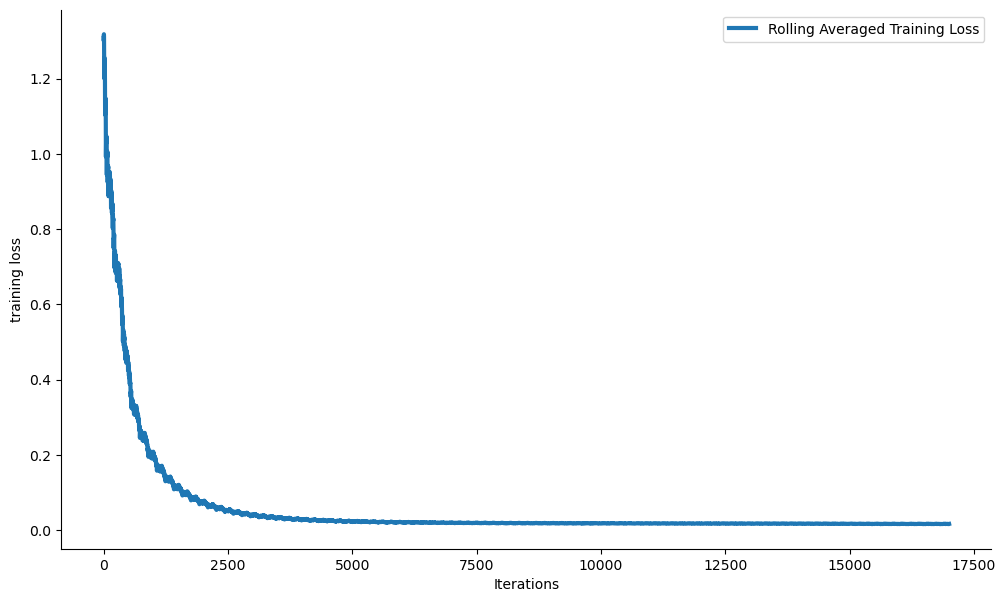

In [210]:
plt.figure(figsize = (12, 7))

plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

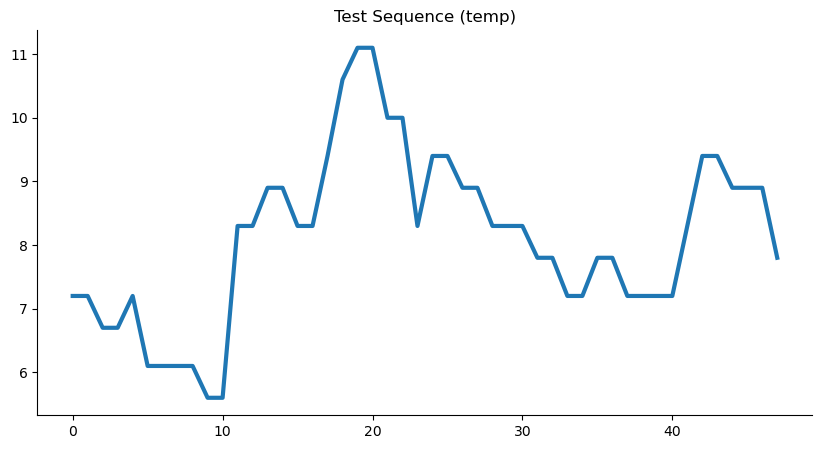

In [211]:
# Let's visualize our test sequence
plt.figure(figsize = (10, 5))
plt.plot(test_target_seq, linewidth = 3)
plt.title('Test Sequence (temp)')
sns.despine()

In [212]:
# Define the test sequence (t_avg)
test_input_seq = y_scaled[-testing_sequence_len:]
test_input_seq.shape

(48, 1)

In [213]:
# # Initialize index for prediction
# pred_start_ind = 0


# # initialize empty torch tensor array to store decoder output sequence
# # This should be the same size as the test sequence
# decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

# # Convert test sequence to ten  sor
# test_input_seq = torch.from_numpy(test_input_seq).float()
# print(test_input_seq.shape)

# # First n-datapoints in decoder output sequence = First n-datapoints in ground truth test sequence
# # n = encoder_input_seq_len
# decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]




In [214]:
# input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
# # Add dimension to first dimension to keep the input (sample_size, seq_len, # of features/timestep)
# input_test_seq = torch.unsqueeze(input_test_seq, 0)
# print(input_test_seq)
# decoder_input = input_test_seq[:, -1, :]
# print(decoder_input)
# decoder_input = torch.unsqueeze(decoder_input, 1)
# print(decoder_input, decoder_input.shape)


In [215]:
# USE TEACHER FORCING METHOD WHEN GENERATING OUTPUTS FROM DECODER
# See slide 42 of Lab 5 or Lab 5 part 2 video to recap the concept of teacher forcing method
# When generating decoder outputs, make sure each input to decoder at timestep t has the shape (1,1,1)
# i.e., num_samples = 1, sequence_len = 1, num_features = 1 

test_input_seq = y_scaled[testing_sequence_len: 2 * testing_sequence_len]

if (isinstance(test_input_seq, np.ndarray)):
    test_input_seq = torch.from_numpy(test_input_seq).float()

# initialize empty torch tensor array to store decoder output sequence
# This should be the same size as the test sequence
decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

# First n-datapoints in decoder output sequence = First n-datapoints in ground truth test sequence
# n = encoder_input_seq_len
decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]

# Initialize index for prediction
pred_start_ind = 0

# Activate no_grad() since we aren't performing backprop
with torch.no_grad():
    
    # Loop continues until the RNN prediction reaches the end of the testing sequence length
    while pred_start_ind + encoder_inputseq_len + decoder_outputseq_len < testing_sequence_len:
        
        # initialize hidden state for encoder
        hidden_state = None
        
        # Define the input to encoder
        input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
        # Add dimension to first dimension to keep the input (sample_size, seq_len, # of features/timestep)
        input_test_seq = torch.unsqueeze(input_test_seq, 0)
        
        # Feed the input to encoder and set resulting hidden states as input hidden states to decoder
        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(input_test_seq, hidden_state)
        decoder_hidden = encoder_hidden
        
        # Initial input to decoder is last timestep feature from the encoder input sequence 
        decoder_input = input_test_seq[:, 1, :]
        # Add dimension to keep the input (sample_size, seq_len, # of features/timestep)
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Populate decoder output sequence
        for t in range(decoder_outputseq_len):
            
            # Generate new output for timestep t
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            # Populate the corresponding timestep in decoder output sequence
            decoder_output_seq[pred_start_ind + encoder_inputseq_len + t] = torch.squeeze(decoder_output)
            # Use the output of the decoder as new input for the next timestep
            #print(decoder_output)
            #print(torch.unsqueeze(torch.unsqueeze(test_input_seq[t], -1), -1))
            decoder_input = test_input_seq[pred_start_ind + encoder_inputseq_len + t]
            decoder_input = torch.reshape(decoder_input, (1, 1, 1))
        
        # Update pred_start_ind
        pred_start_ind += decoder_outputseq_len

In [216]:
# t = np.arange(8).reshape((2, 4))
# print(t)
# decoder_input = t[:, -1]
# print(decoder_input, decoder_input.shape)

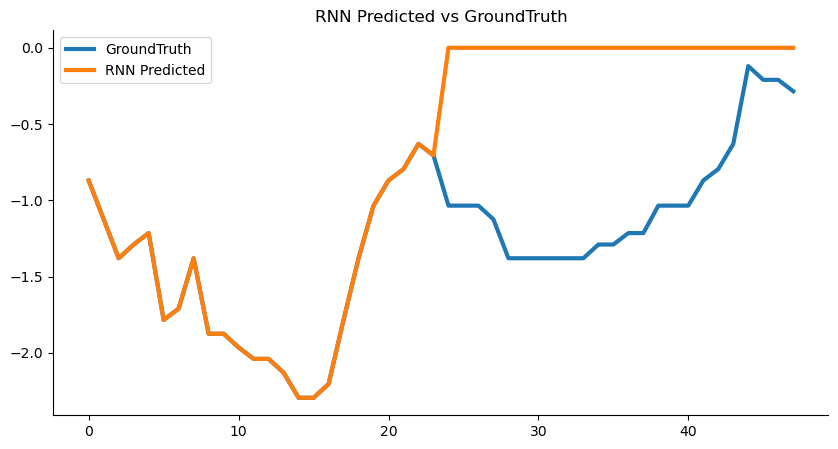

In [217]:
# Compare the RNN prediction (decoder output sequence) vs the ground truth sequence
plt.figure(figsize = (10, 5))

plt.plot(test_input_seq[:, 0], linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq[:, 0], linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [218]:
# Save model

torch.save(Encoder_Decoder_RNN.state_dict(), f'model: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M")}.pth')